In [4]:
import pathlib
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ROOT   = pathlib.Path.cwd().parent          # D:\COGBCI
RAWDIR = ROOT / 'results' / 'features_all.csv'
# 1. 載入特徵資料（請確認路徑正確）
df = pd.read_csv(RAWDIR)  # 假設 notebook 位於 notebooks/ 底下

# 2. 聚合成每位受試在每個條件的平均特徵
df['load'] = df['cond'].map({'0b': 0, '1b': 1, '2b': 2})
agg = df.groupby(['sub', 'load']).agg({
    'p300_mean': 'mean',
    'theta_mean': 'mean'
}).reset_index()

X = agg[['p300_mean', 'theta_mean']].values
y = agg['load'].values  # 0,1,2 分別對應 0-back,1-back,2-back

# 3. 定義 10-fold 分層交叉驗證
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

LDA 10-fold CV Accuracy: 0.367 ± 0.180
LDA 10-fold CV Weighted F1: 0.295 ± 0.163



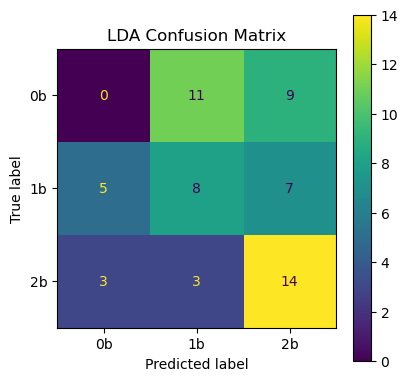

In [5]:
# 4A. LDA 模型
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())
lda_acc = cross_val_score(lda, X, y, cv=cv, scoring='accuracy')
lda_f1  = cross_val_score(lda, X, y, cv=cv, scoring='f1_weighted')
print("LDA 10-fold CV Accuracy: %.3f ± %.3f" % (lda_acc.mean(), lda_acc.std()))
print("LDA 10-fold CV Weighted F1: %.3f ± %.3f\n" % (lda_f1.mean(), lda_f1.std()))

# 4B. 繪製 LDA 混淆矩陣
y_pred_lda = cross_val_predict(lda, X, y, cv=cv)
cm_lda = confusion_matrix(y, y_pred_lda, labels=[0,1,2])
disp_lda = ConfusionMatrixDisplay(confusion_matrix=cm_lda, display_labels=['0b','1b','2b'])
fig, ax = plt.subplots(figsize=(4.5,4.5))
disp_lda.plot(ax=ax)
ax.set_title("LDA Confusion Matrix")
plt.show()

SVM 10-fold CV Accuracy: 0.367 ± 0.180
SVM 10-fold CV Weighted F1: 0.286 ± 0.159



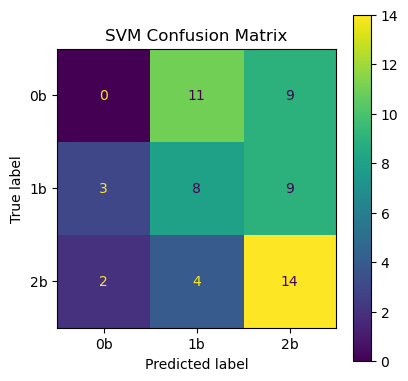

In [6]:
# 5A. SVM (linear kernel)
svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm_acc = cross_val_score(svm, X, y, cv=cv, scoring='accuracy')
svm_f1  = cross_val_score(svm, X, y, cv=cv, scoring='f1_weighted')
print("SVM 10-fold CV Accuracy: %.3f ± %.3f" % (svm_acc.mean(), svm_acc.std()))
print("SVM 10-fold CV Weighted F1: %.3f ± %.3f\n" % (svm_f1.mean(), svm_f1.std()))

# 5B. SVM 混淆矩陣
y_pred_svm = cross_val_predict(svm, X, y, cv=cv)
cm_svm = confusion_matrix(y, y_pred_svm, labels=[0,1,2])
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=['0b','1b','2b'])
fig, ax = plt.subplots(figsize=(4.5,4.5))
disp_svm.plot(ax=ax)
ax.set_title("SVM Confusion Matrix")
plt.show()

In [7]:
# 6. 儲存到 CSV
results = {
    'Model': ['LDA', 'SVM'],
    'Accuracy Mean': [lda_acc.mean(), svm_acc.mean()],
    'Accuracy Std':  [lda_acc.std(),  svm_acc.std()],
    'F1 Mean':       [lda_f1.mean(),  svm_f1.mean()],
    'F1 Std':        [lda_f1.std(),   svm_f1.std()]
}
df_results = pd.DataFrame(results)
df_results.to_csv('../results/classification_report.csv', index=False)
print("Classification results saved to results/classification_report.csv")

Classification results saved to results/classification_report.csv


In [8]:
import numpy as np
import pathlib

RES_DIR = pathlib.Path('../results')
RES_DIR.mkdir(exist_ok=True)


y_pred_lda = cross_val_predict(lda, X, y, cv=cv)
# --------------------------------

np.save(RES_DIR / 'y_true.npy', y)
np.save(RES_DIR / 'y_pred_lda.npy', y_pred_lda)

y_pred_svm = cross_val_predict(svm, X, y, cv=cv)
np.save(RES_DIR / 'y_pred_svm.npy', y_pred_svm)
# ---------------------------------